## Image Classification using NNs

The first stage of deep-learning development is data preparation where we acquire data to train and test our models.

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html), [TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html), all of which include datasets. 

The ``torchvision.datasets`` module contains many real-world vision data like MNIST, Fashion-MNIST, CIFAR, COCO,... ([full list here](https://pytorch.org/vision/stable/datasets.html)). 

Here we will be using the Fashion-MNIST dataset. Fashion MNIST is a drop-in replacement of MNIST. It has the exact same
format as MNIST (70,000 grayscale images of 28 × 28 pixels each, with 10 classes), but the images represent fashion items rather than handwritten digits.
Of the 70,000 images, 60,000 are training examples and 10,000 are test examples.

The dataset object returns the data in the form of Python Imagine Library (PIL) images, which we convert to tensors by passing a `transform=ToTensor()` parameter. 


In [1]:
import torch
from torchvision import datasets
from torchvision import transforms

train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms.ToTensor() # NN needs tensors as input; this transform is applied whenver the dataset is accessed
   
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
 
)

26422272it [00:34, 760111.16it/s]                              


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



29696it [00:00, 30693457.76it/s]         


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



4422656it [00:00, 12163495.90it/s]                             


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



6144it [00:00, 393949.37it/s]           

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



In [ ]:
print('Training samples:', len(train_data))
print('Test samples:', len(test_data))

In [4]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

#### Exploring the Dataset

We can index ``Datasets`` manually like a list: ``train_data[index]``. 




In [5]:
img_tensor, label = train_data[0] # returns a tuple

In [6]:
type(img_tensor), type(label)

(torch.Tensor, int)

In [7]:
img_tensor.shape  # [channels, height, width]

torch.Size([1, 28, 28])

All pixel intensities of the images are represented by floating-point values in between 0 and 1:

In [8]:
# conversion from uint8 to float happens as part of ToTensor()

print('Min intensity value: ', img_tensor.min().item())
print('Max intensity value: ', img_tensor.max().item())

Min intensity value:  0.0
Max intensity value:  1.0


We will use matplotlib to visualize the image:

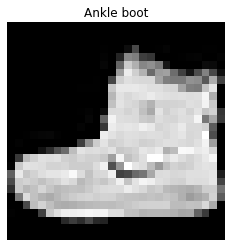

In [9]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor.squeeze(), cmap='gray') # or img_tensor.view(28,28)
plt.axis("off")
plt.title(train_data.classes[label]);

Typically, when training and testing the model, we will pass small **batches** of data at each iteration, rather than one sample at a time. Sending data in batches not only allows more efficient training but also takes advantage of the parallel nature of GPUs. PyTorch has an object called **DataLoader** that can create batches of our data for us automatically

In [10]:
# Dataloader is an iterable
#  We pass the dataset as an argument to the dataloader

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16)


## Fully-connected neural networks


Fashion-MNIST is a classification problem. We will start with the simplest possible approach for image classification - a fully-connected neural network


A basic **neural network** in PyTorch consists of a number of **layers**. The simplest network would include just one fully-connected layer, which is called **Linear** layer, with 784 inputs (one input for each pixel of the input image) and 10 outputs (one output for each class).

![A graph showing how an image is broken into layers based on the pixels.](./fig1.png)


It can be defined in PyTorch in the following way, using `Sequential` syntax. 
As we discussed above, the dimension of our images is $1\times28\times28$. Because the input dimension of a fully-connected layer is 784, 
we need to insert another layer into the network, called **Flatten**, to change tensor shape from $1\times28\times28$ to $784$.

In [11]:
from torch import nn
model = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax(dim=1)
        )

[nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is an ordered 
container of modules. The data is passed through all the modules in the same order as defined. You can use
sequential containers to put together a quick network

[nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) 
layer converts each 2D 28x28 image into a contiguous array of 784 pixel values (the minibatch dimension (at dim=0) is maintained).

[nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
is a module that applies a linear transformation on the input using it's stored weights and biases.

We want $n$-th output of the network to return the probability of the input image belonging to class $n$. Because the output of a fully-connected layer
is not normalized to be between 0 and 1, it cannot be thought of as probability. To turn it into a probability we need to apply another layer called
[nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
In PyTorch, it is easier to use [nn.LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html), which will also compute logarithms of output probabilities. 

To turn the output vector into the actual probabilities, we need to take `torch.exp()` of the output.


Thus, the architecture of our network can be represented by the following sequence of layers:

![An image showing the architecture of the network broken into a sequence of layers.](./onelayer-network-layers-fashion-mnist1.png)


In [12]:
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): LogSoftmax(dim=1)
)


#### Predicting Class Probabilities

A network defined this way can take images as input and produce a vector of probabilities as an output for each image. Let's see how this network performs by giving it a batch of 16 images:

In [14]:
# We need to use iter() to cast the trainloader to an iterator
# and then use next() to iterate over the data one more time.
# This is only necessary when accessing one batch. As we’ll see
# later, our training loops will access the dataloader directly
# without the need for iter() and next().

inputs, labels = next(iter(train_loader))
outputs = model(inputs)
print(inputs.shape, outputs.shape)
torch.exp(outputs)

torch.Size([16, 1, 28, 28]) torch.Size([16, 10])


tensor([[0.0886, 0.0872, 0.0667, 0.0861, 0.0825, 0.1282, 0.0936, 0.0981, 0.1848,
         0.0843],
        [0.1541, 0.0855, 0.0594, 0.0892, 0.1056, 0.0951, 0.1060, 0.1089, 0.1216,
         0.0745],
        [0.1016, 0.0912, 0.0968, 0.0883, 0.1123, 0.0992, 0.0931, 0.0917, 0.1278,
         0.0981],
        [0.1072, 0.0960, 0.0919, 0.0885, 0.1280, 0.1027, 0.0922, 0.0998, 0.1073,
         0.0862],
        [0.1029, 0.0880, 0.0816, 0.0758, 0.1260, 0.0925, 0.0912, 0.1024, 0.1396,
         0.0999],
        [0.1112, 0.0895, 0.0774, 0.0611, 0.1015, 0.1096, 0.1130, 0.1266, 0.1347,
         0.0753],
        [0.0737, 0.0976, 0.0981, 0.0911, 0.0872, 0.1186, 0.1190, 0.1285, 0.0942,
         0.0921],
        [0.1055, 0.0857, 0.0597, 0.0436, 0.0991, 0.1147, 0.0919, 0.1440, 0.1935,
         0.0622],
        [0.0779, 0.1032, 0.0837, 0.1119, 0.1009, 0.0994, 0.1063, 0.1092, 0.1118,
         0.0957],
        [0.1044, 0.1186, 0.0795, 0.0949, 0.0960, 0.1170, 0.0943, 0.0994, 0.1161,
         0.0798],
        [0

As you can see the network predicts similar probabilities for each class. This is because it has not been trained on how to recognize the classes. We need to give it our training data to train it on our dataset.

#### Training the Network

The training process steps are as follows:

1. We take a minibatch from the input dataset, which consists of input images and expected result (label).
2. We calculate the predicted result for this minibatch. 
3. The difference between this result and expected result is calculated using a special function called the **loss function**.  In most of the classification tasks `NLLLoss` is used.
4. We calculate the gradients of this loss function with respect to model weights (parameters), which are then used to adjust the weights to optimize the performance of the network. The amount of adjustment is controlled by a parameter called **learning rate**.  **Learning rate** defines the speed at which the network learns. If the learning rate is too high, new values will overwrite the knowledge from the old ones, and the network would perform unpredictably. If the learning rate is too small it results in a very slow learning process. The details of optimization algorithm are defined in the **optimizer** object. The most traditional algorithm is *stochastic gradient descent*, but we will use a more advanced version called **Adam** 
5. We repeat those steps until the whole dataset is processed. One complete pass through the dataset is called **an epoch**. 



In [ ]:
#  The loss function determines how we measure the performance of our model and
# computes the loss or error between predictions and truth. We’ll
# attempt to minimize the loss by adjusting the model parameters
# during training. The optimizer defines how we update our
# model’s parameters during training


# To define the loss function and the optimizer, we use the
# `torch.optim` and `torch.nn` packages :
from torch import optim
from torch import nn

loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), # PyTorch optimizers require that you pass in the model parameters using the parameters() method
                      lr=0.001)

Inside the training loop, optimization happens in three steps:
 * Call `optimizer.zero_grad()` to reset the gradients of model parameters. Gradients by default add up; to prevent accumulation, we explicitly zero them at each iteration.
 * Back-propagate the prediction loss with a call to `loss.backward()`. PyTorch computes the gradients of the loss w.r.t. each parameter. 
 * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.

The following PyTorch code demonstrates the fundamental training loop:

In [ ]:
n_epochs=5
for epoch in range(n_epochs): # 

    epoch_loss = 0.0
    for inputs, labels in train_loader:
        
        # Compute prediction and loss
        outputs = model(inputs) # 
        loss = loss_fn(outputs, labels) # 

        # Backpropagation
        optimizer.zero_grad() # 
        loss.backward() #
        optimizer.step() #

        epoch_loss += loss.item() #
    print(f'Epoch:{epoch+1} Loss:{epoch_loss/len(train_loader):.3f}')

Here is what we do when training:
* For each epoch:
* Go over all batches in the dataset, and for each batch (`inputs`) do the following:
   - compute predictions made by the network on this batch (`outputs`)
   - compute `loss`, which is the discrepancy between predicted and expected values
   - try to minimize the loss by adjusting weights of the network (`optimizer.step()`)
   
   
By observing the loss during training we can see whether the network is improving and learning from the data provided.

Now that we have trained our model and attempted to minimize
the loss, how can we evaluate its performance? How do
we know that our model will generalize and work with data it
has never seen before?

Model development often includes validation
to ensure that overfitting does not occur and that the model
will perform well against unseen data. Typically, we will reserve a portion of the training data for validation.
The validation data will not be used to train the NN;
instead, we’ll use it to test the performance of the model at the
end of each epoch. 

Before we perform validation, we need to split our training
dataset into a training dataset and a validation dataset, as
shown in the following code:


In [20]:
from torch.utils.data import random_split

train_set, val_set = random_split(
                      train_data, 
                      [50000, 10000])

train_loader = torch.utils.data.DataLoader(
                    train_set, 
                    batch_size=16)

val_loader = torch.utils.data.DataLoader(
                    val_set, 
                    batch_size=16)

In [ ]:
print(len(train_loader), len(val_loader))

The following code shows the previous fundamental training
example with validation added:

In [ ]:
# Re-initialize the network to start from scratch
model = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax(dim=1))
        
loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)

n_epochs = 5
for epoch in range(n_epochs):

    # Training 
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()

    print(f"Epoch: {epoch+1} Train Loss: {train_loss/len(train_loader):.3f} Val Loss: {val_loss/len(val_loader):.3f}")
                  

All this might seem a little complicated process, but in real life, we need to write this code once as a function , and then reuse the function when needed:

In [21]:
def train_val(model, train_loader, val_loader, optimizer = None, lr = 0.001, n_epochs=5, loss_fn = nn.NLLLoss()):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    optimizer = optimizer or torch.optim.Adam(model.parameters(), lr=lr)

    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(n_epochs):

        # Training 
        running_loss , num_correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _,predicted = torch.max(outputs,1)
            num_correct += (predicted == labels).sum().item()           

        train_loss = running_loss/len(train_loader) 
        train_acc = num_correct/len(train_loader.dataset) 
        res['train_loss'].append(train_loss)        
        res['train_acc'].append(train_acc)

        # Validation
        running_loss, num_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()
                _,predicted = torch.max(outputs,1)
                num_correct += (predicted == labels).sum().item()            

            val_loss = running_loss/len(val_loader) 
            val_acc = num_correct/len(val_loader.dataset) 
            res['val_loss'].append(val_loss)        
            res['val_acc'].append(val_acc)

        print(f"Epoch {epoch:2}, Train acc={train_acc:.3f}, Val acc={val_acc:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
    return res

In [ ]:
# Re-initialize the network to start from scratch
model = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax(dim=1))

history=train_val(model, train_loader,val_loader, n_epochs=10)

This function logs messages with the accuracy on training and validation data from each epoch. It also returns this data as a dictionary (called **history**). We can then visualize this data to better understand our model training.

In [28]:
import matplotlib.pyplot as plt
def plot_results(history):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history['train_acc'], label='Training acc')
    plt.plot(history['val_acc'], label='Validation acc')
    plt.legend()
    plt.subplot(122)
    plt.plot(history['train_loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.legend()
    


In [ ]:
plot_results(history)

These graphs indicate that the model is **overfitted**. 

#### Testing
The model has never seen the test data during training, nor has
the test data had any influence on the hyperparameters. Let’s
see how we perform against a test image:

In [ ]:

output = model(test_data[0][0].to(device))
print('Class Probabilites:', torch.exp(output))
print('Predicted Class:', torch.argmax(output, dim=1).item())
print('True Class:', test_data[0][1])

In [ ]:
plt.imshow(test_data[0][0].view(28,28))

To test on the entire test set, we use the `DataLoader` class to create iterable batches:

In [22]:
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor() 
)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=16) # we can use larger batch size for testing
test_loader.batch_size

16

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
num_correct = 0
for inputs, labels in test_loader:
    labels = labels.to(device)
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    num_correct += (predicted == labels).float().sum()

accuracy = num_correct/len(test_loader.dataset)


print(f"Test Accuracy: {accuracy:.3f}")


#### Visualizing network weights

Now let's visualize our weights of our neural network and see what they look like. When the network is more complex than just one layer it can be a difficult to visulize the results like this. However, in our case it happens by multiplying the initial image by a weight matrix allowing us to visualize the network weights with a bit of added logic.

This results in the weight tensor elements somewhat resembling the average shape of the item it classifies:

In [ ]:
model = model.to('cpu')
weight_tensor = next(model.parameters()) #10x784 tensor
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).detach())

In [ ]:
test_data.classes

We can see that a single-layer dense neural network shows relatively good performance, but we want to get higher than 84% on accuracy! Let us see if we can get better performance by adding more layers

## Multi-layer perceptron

In a multi-layer network, we will add one or more **hidden layers**.

![An image showing a multi-layer network with a hidden layer between the input layer and the output layer.](./dense-multilayer-network-fashionmnist-small.png)

This layer may contain any number of neurons, which will affect how powerful our neural network it, i.e. how many parameters will it have. The more parameters there are in the network - the more data we need to train it.

However, _more_ is not always _better_. A number of parameters of a neural network should be chosen depending on the dataset size, to prevent **overfitting**.

Our network layer structure will look like this:

![An image showing the network layer structure as it's broken down into layers.](./multilayer-network-layers-fashionmnist-small.png)

An important thing to note here is the non-linear activation function layer, called **ReLU**. It is important to introduce those non-linear activation functions, because they are one of the reasons neural networks achieve high expressive power. Indeed, it can be demonstrated mathematically that if a network consisted just of a series of linear layers, it would essentially be equivalent to one linear layer. Thus inserting non-linear functions in between layers is important!


Our network can be defined in PyTorch in the following way, using `Sequential` syntax:

In [23]:
from torch import nn
net2 = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=1))

print(net2)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)


In [ ]:
hist = train_val(net2, train_loader, val_loader, n_epochs=10)
plot_results(hist)

#### Takeaway

Multi-level networks can achieve higher accuracy than single-layer perceptron, however, they are not perfect for computer vision tasks. In images, there are some structural patterns that can help us classify an object regardless of it's position in the image, but perceptrons do not allow us to extract those patterns and look for them selectively. Convolutional Neural Networks(CNNs) and Vision Transformers(ViTs) are more effective for computer vision tasks.

## Class-based network definitions

Defining models using a `Sequential` style as a list of layers seems very convenient but it is somewhat limited. PyTorch provides tremendous flexibility to a programmer about how to create, combine, and process tensors as they flow through a network (called computational graph) paired with a relatively high-level, object-oriented API.  This means we need to utilize a little bit of object oriented programming (OOP) in Python.

[Primer on object oriented programming in Python
](./intro_oop-pres.ipynb)

We define our neural network by subclassing `nn.Module`, and 
initialize the neural network layers in `__init__`. The operations on input data are defined in the `forward` method.

In [24]:
from torch import nn
from torch.nn import functional as F

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        x = F.log_softmax(x,dim=1)
        return x


In [25]:
net = MyNet()
print(net)

MyNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
)


You can see that the structure of a neural network is the same as with the `Sequential`-defined network, but the definition is more explicit. Our custom neural network is represented by a class inherited from [``torch.nn.Module``](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class.

Class definition consists of two parts:
* In the constructor (`__init__`) we define all layers that our network will have. Those layers are stored as internal variables of the class, and PyTorch will automatically know that parameters of those layers should be optimized when training. Internally, PyTorch uses `parameters()` method to look for all trainable parameters, and `nn.Module` will automatically collect all trainable parameters from all sub-modules. 
* We define the `forward` method that does the forward pass computation of our neural network. In our case, we start with a parameter tensor `x`, and explicitly pass it through all the layers and activation functions, starting from `flatten`, up to final linear layer `out`.

To use the model, we pass it the input data `x` by writing `out = net(x)`. This executes the model's `forward`,
along with some [background operations](https://github.com/pytorch/pytorch/blob/270111b7b611d174967ed204776985cefca9c144/torch/nn/modules/module.py#L866). Do not call `model.forward()` directly!


In fact, `Sequential` networks are represented in a very similar manner, they just store a list of layers and apply them sequentially during the forward pass. Here we have a chance to represent this process more explicitly, which eventually gives us more flexibility. That is one of the reasons that using classes for neural network definition is a recommended and perfered practice.

Now we will train our network and make sure we get similar results as before:

In [32]:
hist = train_val(net, train_loader, val_loader, n_epochs=10)

Epoch  0, Train acc=0.815, Val acc=0.847, Train loss=0.526, Val loss=0.422
Epoch  1, Train acc=0.860, Val acc=0.859, Train loss=0.392, Val loss=0.383
Epoch  2, Train acc=0.873, Val acc=0.865, Train loss=0.351, Val loss=0.363
Epoch  3, Train acc=0.882, Val acc=0.866, Train loss=0.324, Val loss=0.359
Epoch  4, Train acc=0.888, Val acc=0.871, Train loss=0.306, Val loss=0.355
Epoch  5, Train acc=0.893, Val acc=0.867, Train loss=0.289, Val loss=0.372
Epoch  6, Train acc=0.897, Val acc=0.871, Train loss=0.276, Val loss=0.361
Epoch  7, Train acc=0.901, Val acc=0.873, Train loss=0.263, Val loss=0.358
Epoch  8, Train acc=0.907, Val acc=0.877, Train loss=0.252, Val loss=0.352
Epoch  9, Train acc=0.909, Val acc=0.876, Train loss=0.243, Val loss=0.370


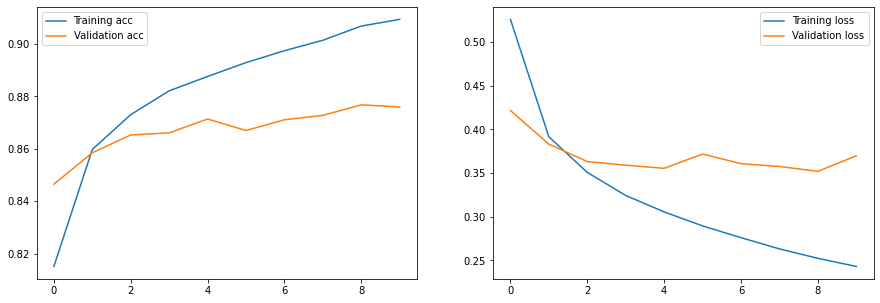

In [33]:
plot_results(hist)

Only modules which contains weights which you want to be trained during the training process should be defined in your `__init__` method.
You don't need do define activation functions like softmax, ReLU or sigmoid in your `__init__`, you can just call them in forward.

If you define, say, a Linear layer in the forward function of your model, then the scope of this "layer" and its trainable parameters is local to the function and will be discarded after every call to the forward method. You cannot update and train weights that are constantly being discarded after every forward pass.
However, when the Linear layer is a member of your model its scope extends beyond the forward method and the trainable parameters persists as long as the model object exists. This way you can update and train the model and its weight

## Transfer Learning Example
Say, we want to classify images of ants and bees with a small dataset. ([Download](https://www.kaggle.com/gauravduttakiit/ants-bees) the dataset from Kaggle)

Training big models from scratch require lot of data to make sure that
the training signal gets to all parts of the architecture and trains them significantly. But we have only a small dataset. Can we look for pre-trained models? Indeed, Pytorch makes available many famous pre-trained models like Alexnet, VGGnet, Resnet etc.. But these models have been trained on Imagenet with 1000 classes. Here is where transfer learning comes in. We take a pre-trained model and slightly alter the architecture to include a new network block at the end-two outputs instead of 1000

In transfer learning, we fine-tune a pretrained model with a much smaller dataset of new images. 

As we did earlier,we’ll leverage functions from the Torchvision library for
creating the datasets, loading the data, and applying the data
transforms. First we'll define our transforms:

In [ ]:
from torchvision import transforms
transforms = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.Resize((256,256)),
    transforms.ToTensor(), 
    transforms.Normalize(
        [0.485, 0.456,0.406], 
        [0.229, 0.224, 0.225])])

Define the datasets:

In [ ]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(
          root='./hymenoptera_data/train',
          transform=transforms)

val_dataset = datasets.ImageFolder(
            root='./hymenoptera_data/val',
            transform=transforms)

In the previous code we used `ImageFolder` dataset to pull
images from our data folders and set the transforms to the ones
we defined earlier. Next, we define our dataloaders for batch
iteration

In [ ]:
import torch
from torch import nn

In [ ]:
train_loader = torch.utils.data.DataLoader(
            train_dataset, 
            batch_size=4,
            shuffle=True
            )

val_loader = torch.utils.data.DataLoader(
            val_dataset, 
            batch_size=4,
            shuffle=True 
            )

In [ ]:
len(train_loader.dataset), len(val_loader.dataset)

#### Load pretrained model:

Torchvision provides many famous pretrained models for
computer vision and image processing [here](https://pytorch.org/vision/main/models.html)

In [ ]:
from torchvision import models
#transfer_model = models.efficientnet_b0(pretrained=True)
transfer_model = models.resnet18(pretrained=True)
print(transfer_model)

Next, we need to freeze the layers

In [ ]:
for param in transfer_model.parameters():
    param.requires_grad = False

Replace the classifier:

In [ ]:
from torch.nn import Linear
transfer_model.fc = Linear(512, 2)

Train the model:

In [ ]:
def train_val(model, train_loader, val_loader, optimizer = None, lr = 0.001, n_epochs=5, loss_fn = nn.NLLLoss()):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)

    optimizer = optimizer or torch.optim.Adam(model.parameters(), lr=lr)

    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(n_epochs):

        # Training 
        model.train()
        running_loss , num_correct = 0.0, 0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _,predicted = torch.max(outputs,1)
            num_correct += torch.sum((predicted == labels)).item()     
              
        #scheduler.step()
        train_loss = running_loss/len(train_loader.dataset) 
        train_acc = num_correct/len(train_loader.dataset) 
        res['train_loss'].append(train_loss)        
        res['train_acc'].append(train_acc)

        # Validation
        model.eval()
        running_loss, num_correct = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()
                _,predicted = torch.max(outputs,1)
                num_correct += (predicted == labels).sum().item()            

            val_loss = running_loss/len(val_loader.dataset) 
            val_acc = num_correct/len(val_loader.dataset) 
            res['val_loss'].append(val_loss)        
            res['val_acc'].append(val_acc)

        print(f"Epoch {epoch:2}, Train acc={train_acc:.3f}, Val acc={val_acc:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
    return res

In [ ]:
from torch import optim
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(
                    transfer_model.parameters(), 
                    lr=0.001)

history=train_val(transfer_model, train_loader,val_loader, optimizer=optimizer, n_epochs=10, loss_fn = loss_fn)